# ML Template - HSC Photo-z

Tuan Do, 2012-07-31

Template for ML projects adapted for photo-z work


In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as u
from collections import Counter

%matplotlib inline
font = {        'size'   : 20}
matplotlib.rc('font', **font)


# 1 Big Picture

What is the problem you want to solve? How do you plan to use and benefit from the the machine learning model? What is your metric for success?

Goal: develop a baseline set of characterization of the HSC v4 dataset. Systematically explore the dataset. 

# 2 Get the data

What data are available to you for training your model? How will you access and download all the data? The type and quantity of data available will often impact your choice in the subsequent stages.



In [2]:
tab = pd.read_csv('/data/HSC/HSC_v4/cleaned_all_specz_flag_forced_forced2_spec_z_matched_online.csv')

# 3 Explore the data

Discover and visualize the data to gain insight. For example, how complete is the dataset? Are there more representatives of certain types of data than others?


In [3]:
tab.head()

,Unnamed: 0,# object_id,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec,specz_flag_homogeneous,ra,...,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma
0,1,42278833428106463,0.00011,0.54891,19.242001,DEEP3-201701-11013115,213.52246,-0.036944,True,213.522449,...,20.979572,19.947130,19.067715,18.589880,18.398716,0.003210,0.001870,0.001047,0.001360,0.002279
1,2,42278695989150320,0.00015,0.54821,19.582001,DEEP3-201701-11013116,213.61903,-0.088530,True,213.619050,...,21.935928,20.279877,19.297018,18.870232,18.658607,0.007159,0.002199,0.001163,0.001322,0.002316
2,5,41030088866680729,0.00002,0.06925,17.190001,DEEP3-201701-11013724,152.32516,-0.450379,True,152.325150,...,18.288635,17.634911,17.292387,17.095787,16.931446,0.000671,0.000516,0.000366,0.000526,0.001313
3,7,41117487156191017,0.00012,0.56580,19.165001,DEEP3-201701-11013854,182.70966,-1.001322,True,182.709648,...,22.071690,20.442038,19.342354,18.947113,18.757706,0.007152,0.002496,0.001147,0.001388,0.002247
4,8,41122709836425861,0.00010,0.44151,18.983000,DEEP3-201701-11013857,183.19406,-0.934613,True,183.194018,...,21.944164,20.366680,19.581245,19.234711,19.079449,0.005164,0.002079,0.001041,0.001563,0.002174


In [4]:
tab.columns

Index(['Unnamed: 0', '# object_id', 'specz_redshift_err', 'specz_redshift',
       'specz_mag_i', 'specz_name', 'specz_ra', 'specz_dec',
       'specz_flag_homogeneous', 'ra', 'dec', 'coord', 'skymap_id',
       'g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag',
       'y_cmodel_mag', 'g_cmodel_magsigma', 'r_cmodel_magsigma',
       'i_cmodel_magsigma', 'z_cmodel_magsigma', 'y_cmodel_magsigma'],
      dtype='object')

## 3.1 Duplicates

In [5]:
print('n rows:',len(tab))
print('n unique object_ids',len(np.unique(tab['# object_id'])))
print('n unique spectroscopic IDs',len(np.unique(tab['specz_name'])))

n rows: 639982
n unique object_ids 635688
n unique spectroscopic IDs 291231


In [6]:
from collections import defaultdict


# this return a generator with name, indices of each duplicate galaxy name
def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() 
                            if len(locs)>1)


In [40]:
# use the generator to figure out all the indices
duplicate_gen = list_duplicates(tab['specz_name'])

# return a lists of list of indicies
#duplicates = [[temp,ind] for temp, ind in duplicate_gen]

# flatten the list and return only the unique values
#ind_duplicates = np.unique([item for sublist in ind_duplicates for item in sublist])


In [9]:
#print('number of duplicate specz_names:', len(duplicates))

In [41]:
# set the duplicate and use_unique in the table 

#tab['duplicate'] = False
#tab['use_unique'] = True

duplicate_bool = np.zeros(len(tab),dtype=bool)   # to indicate the galaxy is duplicate
use_unique_bool = np.ones(len(tab),dtype=bool)   # to indicate the galaxy to use that is unique

# iterate over the duplicates and just assign one of them to be the true match to the specz
for name, ind in duplicate_gen:

    duplicate_bool[ind] = True
    # arbitrarily choose the first duplicate to the T one, set all the others to False
    use_unique_bool[ind[1:]] = False

In [43]:
# set these columns in the pandas data frame. Note this way is much faster than changing the data frame over a loop
tab.loc[:,'duplicate'] = duplicate_bool
tab.loc[:,'use_unique'] = use_unique_bool

In [44]:
tab.head()

,Unnamed: 0,# object_id,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec,specz_flag_homogeneous,ra,...,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma,duplicate,use_unique
0,1,42278833428106463,0.00011,0.54891,19.242001,DEEP3-201701-11013115,213.52246,-0.036944,True,213.522449,...,19.067715,18.589880,18.398716,0.003210,0.001870,0.001047,0.001360,0.002279,True,True
1,2,42278695989150320,0.00015,0.54821,19.582001,DEEP3-201701-11013116,213.61903,-0.088530,True,213.619050,...,19.297018,18.870232,18.658607,0.007159,0.002199,0.001163,0.001322,0.002316,True,True
2,5,41030088866680729,0.00002,0.06925,17.190001,DEEP3-201701-11013724,152.32516,-0.450379,True,152.325150,...,17.292387,17.095787,16.931446,0.000671,0.000516,0.000366,0.000526,0.001313,True,True
3,7,41117487156191017,0.00012,0.56580,19.165001,DEEP3-201701-11013854,182.70966,-1.001322,True,182.709648,...,19.342354,18.947113,18.757706,0.007152,0.002496,0.001147,0.001388,0.002247,True,True
4,8,41122709836425861,0.00010,0.44151,18.983000,DEEP3-201701-11013857,183.19406,-0.934613,True,183.194018,...,19.581245,19.234711,19.079449,0.005164,0.002079,0.001041,0.001563,0.002174,True,True


In [45]:
print('number of duplicates',len(tab[tab['duplicate']]))
print('number of unique values',len(tab[tab['use_unique']]))

number of duplicates 565185
number of unique values 291231


In [46]:
# check that this worked
tab.loc[[1, 148, 5332, 5867, 37491, 40176],:]

,Unnamed: 0,# object_id,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec,specz_flag_homogeneous,ra,...,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma,duplicate,use_unique
1,2,42278695989150320,0.00015,0.54821,19.582001,DEEP3-201701-11013116,213.61903,-0.08853,True,213.61905,...,19.297018,18.870232,18.658607,0.007159,0.002199,0.001163,0.001322,0.002316,True,True
148,194,41210005046716498,0.00015,0.54821,19.582001,DEEP3-201701-11013116,213.61903,-0.08853,True,213.61905,...,19.373997,18.937738,18.725700,0.007277,0.002365,0.001203,0.001328,0.002378,True,False
5332,6493,41210005046690243,0.00015,0.54821,19.582001,DEEP3-201701-11013116,213.61903,-0.08853,True,213.61905,...,19.292475,18.864025,18.651436,0.007204,0.002319,0.001175,0.001304,0.002337,True,False
5867,7159,41210000751735130,0.00015,0.54821,19.582001,DEEP3-201701-11013116,213.61903,-0.08853,True,213.61905,...,19.291302,18.862638,18.651287,0.007255,0.002329,0.001172,0.001308,0.002340,True,False
37491,42971,41210000751763868,0.00015,0.54821,19.582001,DEEP3-201701-11013116,213.61903,-0.08853,True,213.61905,...,19.371220,18.934794,18.724060,0.007328,0.002380,0.001199,0.001331,0.002381,True,False
40176,46008,42278695989177085,0.00015,0.54821,19.582001,DEEP3-201701-11013116,213.61903,-0.08853,True,213.61905,...,19.385218,18.949591,18.738346,0.007315,0.002254,0.001194,0.001349,0.002363,True,False


array([list([0, 250, 7413, 39341]),
       list([1, 148, 5332, 5867, 37491, 40176]), list([2, 7419]), ...,
       list([639773, 639774]), list([639831, 639832]),
       list([639937, 639938])], dtype=object)

291231

In [21]:
# there appears to be a bunch galaxies with the same spec_id
# let's look at the ones with the most duplicates

unique_specz_name, count_specz_name = np.unique(tab['specz_name'],return_counts=True)


In [22]:
ind_count_specz_name = np.argsort(count_specz_name)
max_duplicate_specz_name = unique_specz_name[ind_count_specz_name[-1]]
print('max duplicate specz_name:',count_specz_name[ind_count_specz_name[-1]])
print('name:',max_duplicate_specz_name)

max duplicate specz_name: 20
name: DEEP2DR4uniq_35312


In [23]:
max_duplicate_tab = tab[tab['specz_name']==max_duplicate_specz_name]
max_duplicate_tab

,Unnamed: 0,# object_id,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec,specz_flag_homogeneous,ra,...,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma
47862,54360,41628639804033389,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400578,...,25.230290,24.818722,24.151604,23.610470,23.423447,0.082261,0.057926,0.030279,0.047948,0.069119
47863,54361,42697335041446568,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400857,...,25.232567,25.184134,25.048891,24.307751,24.572601,0.115296,0.117170,0.094276,0.102746,0.212513
212463,253538,41623146540849295,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400864,...,25.314446,25.280417,25.093918,24.421631,24.688498,0.129158,0.138238,0.108035,0.108806,0.236715
212675,253773,41628644098986373,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400578,...,25.249233,24.823254,24.117886,23.601866,23.444393,0.084042,0.058797,0.030247,0.047782,0.071114
212676,253774,41628644098986375,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400862,...,25.234543,25.198204,24.993218,24.385658,24.617556,0.128607,0.136788,0.110923,0.108040,0.225834
270860,319854,42691837483308610,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400670,...,26.060528,26.011368,25.265913,25.696335,24.618870,0.185682,0.186449,0.111382,0.359309,0.204670
318041,376901,41623142245894414,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400676,...,25.915230,26.115976,25.566200,26.042732,24.557814,0.184273,0.213698,0.129822,0.441061,0.190948
343659,411039,41623142245894411,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400579,...,25.263372,24.830990,24.159176,23.634823,23.463627,0.085009,0.060010,0.030071,0.047841,0.069571
343660,411040,41623146540849293,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400579,...,25.245148,24.823799,24.085957,23.583971,23.442524,0.084672,0.060529,0.029953,0.046864,0.070328
343661,411041,41623146540849296,0.00006,0.94745,23.218,DEEP2DR4uniq_35312,353.400635,-0.089669,True,353.400670,...,26.013912,26.131103,25.469246,25.820473,24.649336,0.196304,0.206977,0.112018,0.378968,0.202163


In [34]:
# compute the separation between the specz_ra and specz_dec and the ra and dec of the object
max_duplicate_specz_coord = SkyCoord(max_duplicate_tab['specz_ra']*u.deg,max_duplicate_tab['specz_dec']*u.deg,
                                     frame='icrs')
max_duplicate_obj_coord = SkyCoord(max_duplicate_tab['ra']*u.deg,max_duplicate_tab['dec']*u.deg,
                                     frame='icrs')
max_duplicate_separation = max_duplicate_specz_coord.separation(max_duplicate_obj_coord)
print(max_duplicate_separation.to('arcsec').value)
max_duplicate_tab.loc[:,'separation'] = max_duplicate_separation.to('arcsec')

[0.83307183 0.84213401 0.85636293 0.83422578 0.8441071  0.3180649
 0.33173079 0.8338123  0.83404916 0.32005774 0.82967112 0.8318884
 0.30174072 0.83023382 0.83212483 0.8833399  0.83253928 0.8285754
 0.29607542 0.90063431]


/opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [36]:
max_duplicate_tab[['# object_id','specz_name','specz_ra','specz_dec','ra','dec','specz_mag_i','i_cmodel_mag','separation']]

,# object_id,specz_name,specz_ra,specz_dec,ra,dec,specz_mag_i,i_cmodel_mag,separation
47862,41628639804033389,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400578,-0.089893,23.218,24.151604,0.833072
47863,42697335041446568,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400857,-0.089596,23.218,25.048891,0.842134
212463,41623146540849295,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400864,-0.089605,23.218,25.093918,0.856363
212675,41628644098986373,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400578,-0.089894,23.218,24.117886,0.834226
212676,41628644098986375,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400862,-0.089610,23.218,24.993218,0.844107
270860,42691837483308610,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400670,-0.089588,23.218,25.265913,0.318065
318041,41623142245894414,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400676,-0.089586,23.218,25.566200,0.331731
343659,41623142245894411,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400579,-0.089894,23.218,24.159176,0.833812
343660,41623146540849293,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400579,-0.089894,23.218,24.085957,0.834049
343661,41623146540849296,DEEP2DR4uniq_35312,353.400635,-0.089669,353.400670,-0.089587,23.218,25.469246,0.320058


In [50]:
#max_duplicate_tab.to_csv('max_duplicate.csv')

## 3.2 Investigate matching

In [47]:
# use the i-band color difference and the separation to determine if the matches are good

iband_diff = tab['specz_mag_i'] - tab['i_cmodel_mag']

specz_coord = SkyCoord(tab['specz_ra']*u.deg,tab['specz_dec']*u.deg,
                                     frame='icrs')
obj_coord = SkyCoord(tab['ra']*u.deg,tab['dec']*u.deg,
                                     frame='icrs')
separation = specz_coord.separation(obj_coord)


duplicate_ind = np.where(tab['duplicate'])[0]

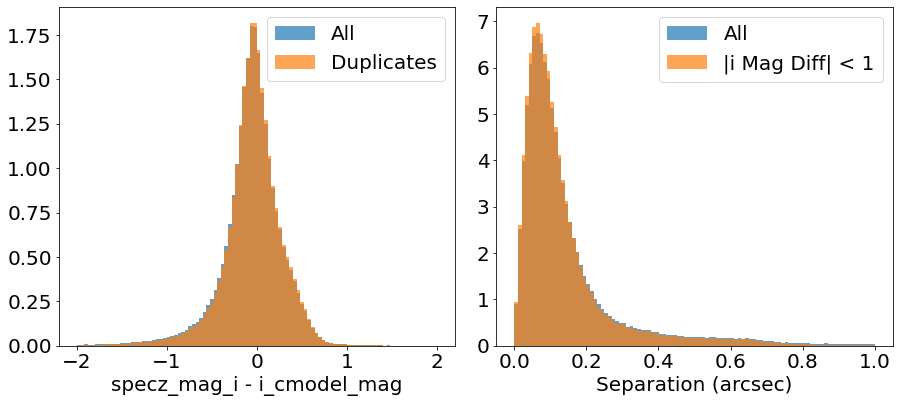

In [50]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
n,bins,patches = plt.hist(iband_diff,bins=100,range=[-2,2],density=True,label='All',alpha=0.7)
n,bins,patches = plt.hist(iband_diff[duplicate_ind],bins=bins,range=[-2,2],
                          label='Duplicates',density=True,alpha=0.7)

plt.xlabel('specz_mag_i - i_cmodel_mag')
plt.legend()
plt.subplot(1,2,2)
n,bins,patches = plt.hist(separation.to('arcsec').value,bins=100,alpha=0.7,label='All',density=True)
n,bins,patches = plt.hist(separation[np.abs(iband_diff)<0.5].to('arcsec').value,bins=bins,density=True,
                          alpha=0.7,label='|i Mag Diff| < 1')

plt.xlabel('Separation (arcsec)')
plt.legend()
plt.tight_layout()

# 4 Prepare Data

Machine learning algorithms often require data to be pre-processed in a certain way, such as scaling numerical values or map categories to other representations. You will also need to decide what data to use as training and as testing. You may also need to develop a strategy to deal with missing data.



# 5 Select a model and train it

Based on the problem and the data, there are often a handful of algorithms to try. Here, experimentation and knowledge of the strengths and weaknesses of machine learning models will help you choose a model and train it.


# 6 Fine tune the model

Most machine learning algorithms will have hyperparameters that can be tuned to improve the performance of the model given the specific dataset. You may also want to visualize the results of model predictions to aid in tuning the model.

# 7 Present your solution and apply it

Here you will evaluate your model against the test set that was set aside in Step 2 to determine the final performance metrics. Your model is now ready to be applied to new data.